In [29]:
import requests, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path


#DATA_FOLDER = Path('C:/Users/calvi/INSY 662_Python/BIXI Project')

In [30]:

model_df = pd.read_csv('BIXI_MODEL.csv')  

In [31]:
model_df['datetime'] = pd.to_datetime(model_df['datetime'], errors='coerce')

### Model 2: Every Column + Historical Average

#### Model 2: Multi Linear Regression

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


#~ split the dataset using the time

t1, t2 = model_df['datetime'].quantile([0.7, 0.85])

train_df = model_df[model_df['datetime'] <= t1].copy()
val_df   = model_df[(model_df['datetime'] > t1) & (model_df['datetime'] <= t2)].copy()
test_df  = model_df[model_df['datetime'] > t2].copy()

print(f"Train: {len(train_df):,}  Val: {len(val_df):,}  Test: {len(test_df):,}")

Train: 1,029,008  Val: 220,509  Test: 220,367


In [33]:

#~ defining features

target = 'total_demand'

numerical_features_m2 = [
    'month',
    'day_of_week',
    'temperature_scaled',
    'wind_speed_scaled',
    'bad_weather',
    'is_weekend',
    'hour_sin',
    'hour_cos',
    'feels_like',
    'is_holiday',
    'temp_hour',
    'temperature_sq',
    'temp_feels_interaction',
    'hour_bucket',
    'weekend_hour_interaction',
    'lat',
    'lon',
    'avg_hourly_demand_station',
    'avg_dayofweek_station'
]

categorical_features_m2 = ['station']

feature_columns_m2 = numerical_features_m2 + categorical_features_m2


In [34]:

#~ Building X/y split Model 2: MLR

X_train_m2 = train_df[feature_columns_m2]
y_train    = train_df[target]

X_val_m2   = val_df[feature_columns_m2]
y_val      = val_df[target]

X_test_m2  = test_df[feature_columns_m2]
y_test     = test_df[target]

In [35]:

#~ building preprocessing + MLR pipeline Model 2
preprocess_m2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_m2),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_m2)
    ],
    remainder='drop'
)

pipe_m2 = Pipeline([
    ('preprocess', preprocess_m2),
    ('model', LinearRegression())
])

In [36]:

#~ train and evaluate on validation

pipe_m2.fit(X_train_m2, y_train)

def eval_metrics(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{name} → R²: {r2:.3f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")

y_train_pred_m2 = pipe_m2.predict(X_train_m2)
y_val_pred_m2   = pipe_m2.predict(X_val_m2)
y_test_pred_m2  = pipe_m2.predict(X_test_m2)

eval_metrics("Model 2 MLR – Validation", y_val, y_val_pred_m2)

Model 2 MLR – Validation → R²: 0.613 | MAE: 5.02 | RMSE: 7.58


In [37]:

#~ overfitting test

print("=== MODEL 2 MLR — OVERFITTING CHECK (TRAIN-FIT) ===")
eval_metrics("Train",      y_train, y_train_pred_m2)
eval_metrics("Validation", y_val,   y_val_pred_m2)
eval_metrics("Test",       y_test,  y_test_pred_m2)

train_r2_mlr = r2_score(y_train, y_train_pred_m2)
val_r2_mlr   = r2_score(y_val,   y_val_pred_m2)
test_r2_mlr  = r2_score(y_test,  y_test_pred_m2)

print(f"Gap (Train - Val):  {train_r2_mlr - val_r2_mlr:.3f}")
print(f"Gap (Train - Test): {train_r2_mlr - test_r2_mlr:.3f}")

=== MODEL 2 MLR — OVERFITTING CHECK (TRAIN-FIT) ===
Train → R²: 0.623 | MAE: 4.73 | RMSE: 7.14
Validation → R²: 0.613 | MAE: 5.02 | RMSE: 7.58
Test → R²: 0.535 | MAE: 4.46 | RMSE: 6.61
Gap (Train - Val):  0.010
Gap (Train - Test): 0.087


In [38]:

#~ retrain on training + validation, evaluate on test (FINAL - MODEL 2: MLR)

X_trval_m2 = pd.concat([X_train_m2, X_val_m2], axis=0)
y_trval_m2 = pd.concat([y_train, y_val], axis=0)

pipe_m2.fit(X_trval_m2, y_trval_m2)

y_test_pred_m2_final = pipe_m2.predict(X_test_m2)
eval_metrics("Model 2 MLR – Test", y_test, y_test_pred_m2)

Model 2 MLR – Test → R²: 0.535 | MAE: 4.46 | RMSE: 6.61


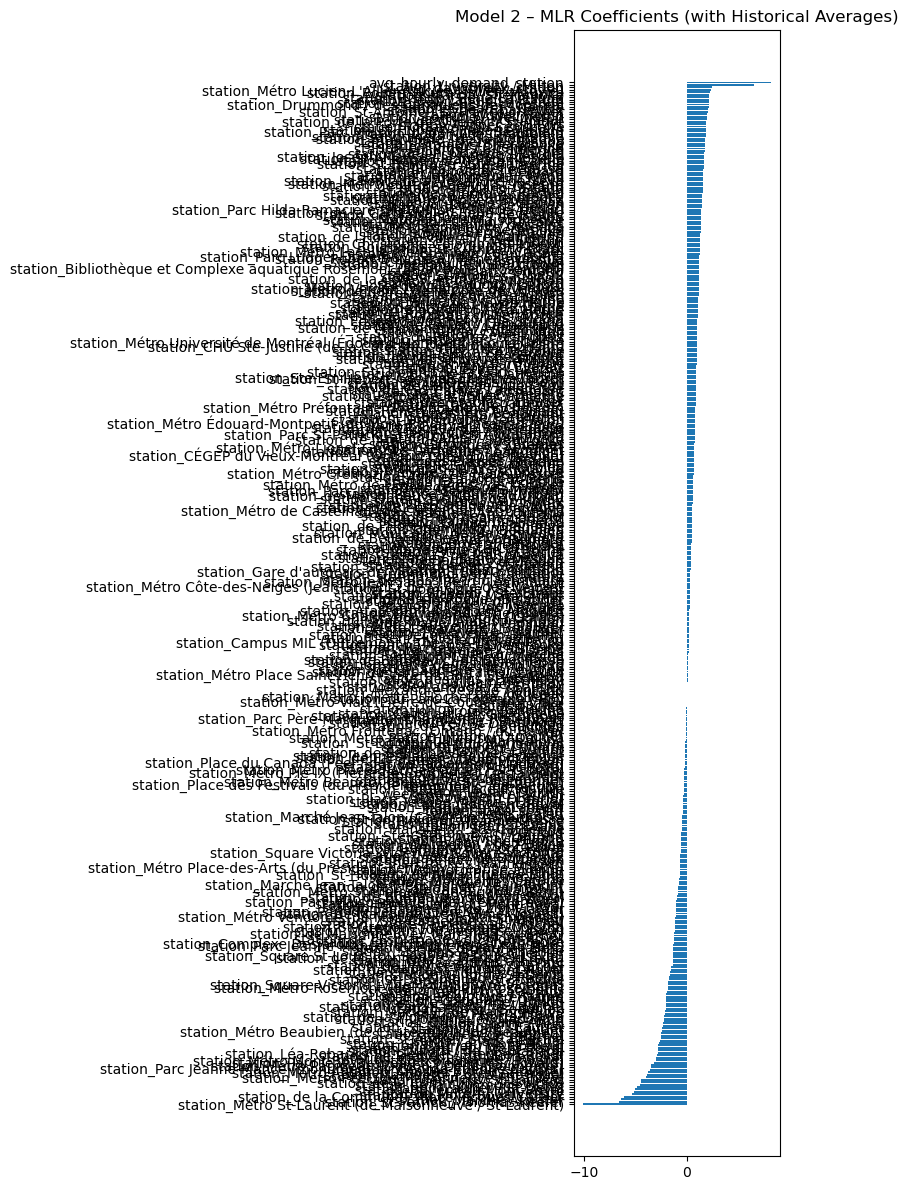

In [39]:

ohe = pipe_m2.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features_m2)

all_features_m2 = numerical_features_m2 + list(cat_feature_names)
coeffs_m2 = pipe_m2.named_steps['model'].coef_

coef_df_m2 = pd.DataFrame({'feature': all_features_m2, 'coef': coeffs_m2})
coef_df_m2 = coef_df_m2.sort_values(by='coef', ascending=False)

plt.figure(figsize=(8,12))
plt.barh(coef_df_m2['feature'], coef_df_m2['coef'])
plt.title("Model 2 – MLR Coefficients (with Historical Averages)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Model 2: Random Forest

In [40]:

model_df['station_encoded'] = model_df['station'].astype('category').cat.codes

In [41]:
t1, t2 = model_df['datetime'].quantile([0.7, 0.85])

train_df = model_df[model_df['datetime'] <= t1].copy()
val_df   = model_df[(model_df['datetime'] > t1) & (model_df['datetime'] <= t2)].copy()
test_df  = model_df[model_df['datetime'] > t2].copy()

print(f"Train: {len(train_df):,},  Val: {len(val_df):,},  Test: {len(test_df):,}")

Train: 1,029,008,  Val: 220,509,  Test: 220,367


In [42]:

numerical_features_rf_m2 = [
    'month',
    'day_of_week',
    'temperature_scaled',
    'wind_speed_scaled',
    'bad_weather',
    'is_weekend',
    'hour_sin',
    'hour_cos',
    'feels_like',
    'is_holiday',
    'temp_hour',
    'temperature_sq',
    'temp_feels_interaction',
    'hour_bucket',
    'weekend_hour_interaction',
    'lat',
    'lon',
    'avg_hourly_demand_station',
    'avg_dayofweek_station'
]


categorical_features_rf_m2 = [
    'station_encoded'
]

feature_columns_rf_m2 = numerical_features_rf_m2 + categorical_features_rf_m2

In [43]:

#~ prepare train/validation/test

X_train_rf_m2 = train_df[feature_columns_rf_m2]
y_train       = train_df[target]

X_val_rf_m2   = val_df[feature_columns_rf_m2]
y_val         = val_df[target]

X_test_rf_m2  = test_df[feature_columns_rf_m2]
y_test        = test_df[target]


In [44]:

#~ running random forest model 

from sklearn.ensemble import RandomForestRegressor

rf_m2 = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,            
    min_samples_split=10,    
    min_samples_leaf=5,      
    max_features='sqrt',     
    max_samples=0.7,        
    n_jobs=-1,
    random_state=42
)


In [45]:

#~ fit on training and evaluate on validation 

rf_m2.fit(X_train_rf_m2, y_train)

y_train_pred_rf_m2 = rf_m2.predict(X_train_rf_m2)
y_val_pred_rf_m2   = rf_m2.predict(X_val_rf_m2)
y_test_pred_rf_m2  = rf_m2.predict(X_test_rf_m2)

eval_metrics("Train", y_train, y_train_pred_rf_m2)
eval_metrics("Validation", y_val, y_val_pred_rf_m2)
eval_metrics("Test", y_test, y_test_pred_rf_m2)

Train → R²: 0.723 | MAE: 4.00 | RMSE: 6.11
Validation → R²: 0.688 | MAE: 4.49 | RMSE: 6.81
Test → R²: 0.635 | MAE: 4.12 | RMSE: 5.86


In [46]:

#~ overfitting test
train_r2_rf = r2_score(y_train, y_train_pred_rf_m2)
val_r2_rf   = r2_score(y_val,   y_val_pred_rf_m2)
test_r2_rf  = r2_score(y_test,  y_test_pred_rf_m2)

print(f"Generalization Gap (Train - Val):  {train_r2_rf - val_r2_rf:.3f}")
print(f"Generalization Gap (Train - Test): {train_r2_rf - test_r2_rf:.3f}")


Generalization Gap (Train - Val):  0.035
Generalization Gap (Train - Test): 0.088


/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_8375/3428607619.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(res_train, label="Train", shade=True)
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_8375/3428607619.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(res_val,   label="Validation", shade=True)
/var/folders/2f/cfhs34m12qx_yvc1ptsr2jyc0000gn/T/ipykernel_8375/3428607619.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(res_test,  label="Test", shade=True)


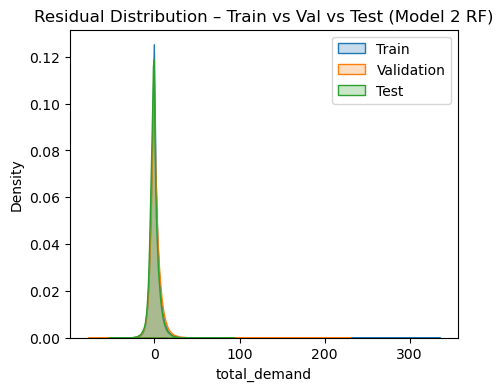

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

res_train = y_train - y_train_pred_rf_m2
res_val   = y_val   - y_val_pred_rf_m2
res_test  = y_test  - y_test_pred_rf_m2

plt.figure(figsize=(5,4))
sns.kdeplot(res_train, label="Train", shade=True)
sns.kdeplot(res_val,   label="Validation", shade=True)
sns.kdeplot(res_test,  label="Test", shade=True)
plt.title("Residual Distribution – Train vs Val vs Test (Model 2 RF)")
plt.legend()
plt.show()


In [48]:

#~ Train on TRAIN + VALIDATION, and then evaluate on TEST set (FINAL - MODEL 2 RANDOM FOREST)

X_trval_rf_m2 = pd.concat([X_train_rf_m2, X_val_rf_m2])
y_trval_rf_m2 = pd.concat([y_train, y_val])

rf_m2.fit(X_trval_rf_m2, y_trval_rf_m2)

y_test_pred_rf_m2_final = rf_m2.predict(X_test_rf_m2)
eval_metrics("Model 2 RF – Test", y_test, y_test_pred_rf_m2)

Model 2 RF – Test → R²: 0.635 | MAE: 4.12 | RMSE: 5.86


In [49]:
importances = rf_m2.feature_importances_
pd.Series(importances, index=feature_columns_rf_m2).sort_values(ascending=False).head(20)


avg_hourly_demand_station    0.452907
avg_dayofweek_station        0.176207
hour_sin                     0.071043
hour_bucket                  0.069358
temp_hour                    0.043485
hour_cos                     0.043073
temperature_scaled           0.024313
day_of_week                  0.022564
bad_weather                  0.018884
temp_feels_interaction       0.015825
temperature_sq               0.009714
weekend_hour_interaction     0.009174
lat                          0.008295
feels_like                   0.007970
lon                          0.007833
station_encoded              0.006146
month                        0.005076
wind_speed_scaled            0.003938
is_weekend                   0.003039
is_holiday                   0.001154
dtype: float64

In [50]:
import joblib
import pickle
import numpy as np

# ============================================================
# SAVE MODELS + METADATA FOR STREAMLIT APP (MODEL 2 ONLY)
# ============================================================

# 1) Save Model 2 – MLR pipeline
joblib.dump(pipe_m2, "model2_mlr_pipeline.pkl")
print("Saved model2_mlr_pipeline.pkl")

# 2) Save Model 2 – Random Forest
joblib.dump(rf_m2, "model2_rf.pkl")
print("Saved model2_rf.pkl")

# 3) Station metadata (station → encoded, lat, lon)
station_meta = (
    model_df[["station", "station_encoded", "lat", "lon"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

stations_sorted = station_meta["station"].sort_values().tolist()
station_to_code = dict(zip(station_meta["station"], station_meta["station_encoded"]))
station_to_lat  = dict(zip(station_meta["station"], station_meta["lat"]))
station_to_lon  = dict(zip(station_meta["station"], station_meta["lon"]))

# 4) Scaling params for temperature & wind_speed
#    (we recompute them here to match StandardScaler behavior: population std, ddof=0)
temp_mean = model_df["temperature"].mean()
temp_std  = model_df["temperature"].std(ddof=0)

wind_mean = model_df["wind_speed"].mean()
wind_std  = model_df["wind_speed"].std(ddof=0)

print("Temperature mean/std:", temp_mean, temp_std)
print("Wind speed mean/std:", wind_mean, wind_std)

# 5) Historical average lookup tables for Model 2
#    These approximate the behaviour of avg_hourly_demand_station & avg_dayofweek_station
hourly_avg_lookup = (
    model_df
    .groupby(["station", "hour"])["avg_hourly_demand_station"]
    .mean()
    .to_dict()
)

dow_avg_lookup = (
    model_df
    .groupby(["station", "day_of_week"])["avg_dayofweek_station"]
    .mean()
    .to_dict()
)

# global fallback means
global_hourly_mean = model_df["avg_hourly_demand_station"].mean()
global_dow_mean    = model_df["avg_dayofweek_station"].mean()

# 6) Save metadata for the app
meta2 = {
    "stations": stations_sorted,
    "station_to_code": station_to_code,
    "station_to_lat": station_to_lat,
    "station_to_lon": station_to_lon,
    "numerical_features_m2": numerical_features_m2,
    "categorical_features_m2": categorical_features_m2,
    "feature_columns_m2": feature_columns_m2,
    "numerical_features_rf_m2": numerical_features_rf_m2,
    "feature_columns_rf_m2": feature_columns_rf_m2,
    "temp_mean": float(temp_mean),
    "temp_std": float(temp_std),
    "wind_mean": float(wind_mean),
    "wind_std": float(wind_std),
    "hourly_avg_lookup": hourly_avg_lookup,
    "dow_avg_lookup": dow_avg_lookup,
    "global_hourly_mean": float(global_hourly_mean),
    "global_dow_mean": float(global_dow_mean),
}

with open("bixi_meta.pkl", "wb") as f:
    pickle.dump(meta2, f)

print("Saved bixi_meta.pkl")

Saved model2_mlr_pipeline.pkl
Saved model2_rf.pkl
Temperature mean/std: 19.179398714456386 5.938499824457523
Wind speed mean/std: 14.425536300823739 7.087536429155381
Saved bixi_meta.pkl
